In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# Data Ingestion

Definisco la cartella contenente i PDB

In [2]:
data_folder = 'refined'

Definisco un metodo <code>extract_atom_coords_and_anchor_points</code> in grado di estrarre
1. la lista delle coordinate degli atomi
2. la lista delle coordinate degli anchor points

In [17]:
def extract_atom_coords_and_anchor_points(filename):
    X = list()                            # coordinate atomiche
    A = list()                            # anchor points
    
    file1 = open(filename, 'r')           # leggo il file
    Lines = file1.readlines()             # estraggo le linee

    
    for line in Lines:
        if line.startswith("ANCHOR"):
            A.append(np.array(line.split()[1:]).astype(float))
        if line.startswith("ATOM"):
            X.append(np.array(line.split())[6:9].astype(float))
    return np.array(X),np.array(A)

# test
X,A = extract_atom_coords_and_anchor_points(r"refined\1ezq\1ezq_pocket.ligen.pdb")

Definisco un metodo <code>build_voxelizations</code> che prese in ingresso la lista delle coordinate atomiche e la lista delle coordinate degli anchor points restituisce le due voxelizzazioni

In [19]:
def build_voxelizations(X,A, size = 32):
    
    X_x_min,X_x_max = X[:,0].min(),X[:,0].max()
    X_y_min,X_y_max = X[:,1].min(),X[:,1].max()
    X_z_min,X_z_max = X[:,2].min(),X[:,2].max()
    A_x_min,A_x_max = A[:,0].min(),A[:,0].max()
    A_y_min,A_y_max = A[:,1].min(),A[:,1].max()
    A_z_min,A_z_max = A[:,2].min(),A[:,2].max()

    x_min, x_max = np.minimum(X_x_min,A_x_min), np.maximum(X_x_max,A_x_max)
    y_min, y_max = np.minimum(X_y_min,A_y_min), np.maximum(X_y_max,A_y_max)
    z_min, z_max = np.minimum(X_z_min,A_z_min), np.maximum(X_z_max,A_z_max)
    
    X_grid = np.zeros((size,size,size))
    A_grid = np.zeros((size,size,size))
    
    # popolo la voxel grid delle coordinate atomiche
    for x in X:
        x_pos = int((x[0] - x_min) / (x_max - x_min) * (size - 1) )
        y_pos = int((x[1] - y_min) / (y_max - y_min) * (size - 1) )
        z_pos = int((x[2] - z_min) / (z_max - z_min) * (size - 1) )
        X_grid[x_pos,y_pos,z_pos] = 1.
    
    # popolo la voxel grid degli anchor point
    for x in A:
        x_pos = int((x[0] - x_min) / (x_max - x_min) * (size - 1) )
        y_pos = int((x[1] - y_min) / (y_max - y_min) * (size - 1) )
        z_pos = int((x[2] - z_min) / (z_max - z_min) * (size - 1) )
        A_grid[x_pos,y_pos,z_pos] = 1.
        
    return X_grid, A_grid

# test
V_X, V_A = build_voxelizations(X,A)

Costruisco un metodo <code>voxelizations_from_file</code> che dato un file pdb in ingresso produce le voxelizzazioni, eventualmente con una callback di data augmentation

In [31]:
identity_augmentation = lambda U,V : (U,V)
def voxelizations_from_file(filename, size = 32, augmentation = identity_augmentation ):
    X,A      = extract_atom_coords_and_anchor_points(filename)
    X,A      = augmentation(X,A)
    V_X, V_A = build_voxelizations(X,A, size)
    return V_X,V_A
V_X, V_A = voxelizations_from_file(r"refined\1ezq\1ezq_pocket.ligen.pdb")

# Data Visualization

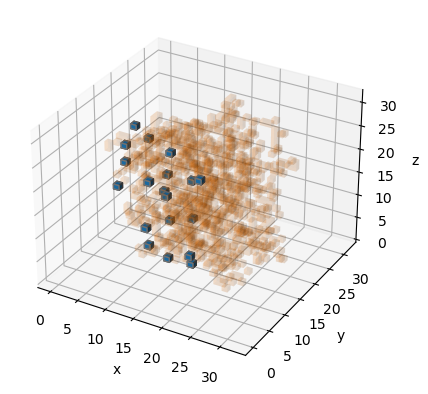

In [36]:
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(V_A, edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

# Data augmentation

Il metodo <code>rotate</code> effettua una rotazione casuale sulla lista dei punti, nell'ottica che <b> una rotazione del sistema di riferimento non altera la posizione relativa gli anchor points </b>

In [37]:
def rotate(X,A):
    rotation = ( np.random.uniform() * 2 * np.pi , np.random.uniform() * 2 * np.pi, np.random.uniform() * 2 * np.pi )
    
    alfa  = rotation[0]
    beta  = rotation[1]
    gamma = rotation[2]
    
    R  = np.array([
        [ np.cos(beta) * np.cos(gamma) , 
          np.sin(alfa)*np.sin(beta)*np.cos(gamma) - np.cos(alfa)*np.sin(gamma), 
          np.cos(alfa)*np.sin(beta)*np.cos(gamma) + np.sin(alfa)*np.sin(gamma)
        ],
        [
          np.cos(beta)*np.sin(gamma) ,
          np.sin(alfa)*np.sin(beta)*np.sin(gamma) + np.cos(alfa) * np.cos(gamma),
          np.cos(alfa)*np.sin(beta)*np.sin(gamma) - np.sin(alfa) * np.cos(gamma)
        ],
        [
            - np.sin(beta),
            np.sin(alfa)*np.sin(beta),
            np.cos(alfa)*np.cos(beta)
        ]
    ])
    
    A_ = A - np.r_[A,X].mean(axis = 0)
    X_ = X - np.r_[A,X].mean(axis = 0)
    A_ = (R @ A_.T).T + np.r_[A,X].mean(axis = 0)
    X_ = (R @ X_.T).T + np.r_[A,X].mean(axis = 0)
    return X_,A_

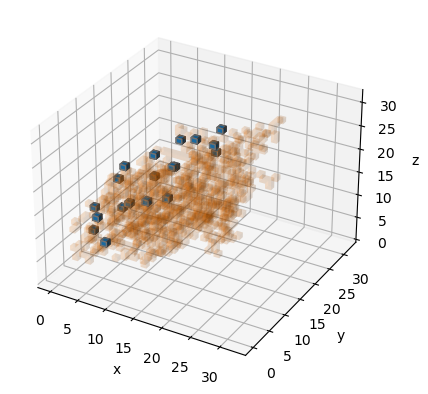

In [43]:
V_X, V_A = voxelizations_from_file(r"refined\1ezq\1ezq_pocket.ligen.pdb",
                                    size = 32,
                                    augmentation = rotate
                                  )
ax = make_ax(True)
ax.voxels(V_A, edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

# Dataset Loading

In [92]:
train_ratio = 0.8

In [107]:
import os

atomcoord_vox_train = []
anchorpts_vox_train = []
atomcoord_vox_test  = []
anchorpts_vox_test  = []

samples = 0
for root, dirnames, filenames in os.walk(data_folder):
        for filename in filenames:
            if filename.endswith(('_pocket.ligen.pdb')):
                samples +=1
                
count = 0
for root, dirnames, filenames in os.walk(data_folder):
        for filename in filenames:
            if filename.endswith(('_pocket.ligen.pdb')):
                for j in range(10):
                    whole_path = '%s\\%s' % (root,filename)
                    V_X,V_A = voxelizations_from_file( whole_path, 
                                                       size = 32, 
                                                       augmentation = rotate)
                    
                    if count <= train_ratio * samples:
                        atomcoord_vox_train.append(V_X)
                        anchorpts_vox_train.append(V_A)
                    else:
                        atomcoord_vox_test.append(V_X)
                        anchorpts_vox_test.append(V_A)    
                    print("%s done [ augmentation %d]" % (whole_path, j))
                count += 1

refined\10gs\10gs_pocket.ligen.pdb done [ augmentation 0]
refined\10gs\10gs_pocket.ligen.pdb done [ augmentation 1]
refined\10gs\10gs_pocket.ligen.pdb done [ augmentation 2]
refined\10gs\10gs_pocket.ligen.pdb done [ augmentation 3]
refined\10gs\10gs_pocket.ligen.pdb done [ augmentation 4]
refined\10gs\10gs_pocket.ligen.pdb done [ augmentation 5]
refined\10gs\10gs_pocket.ligen.pdb done [ augmentation 6]
refined\10gs\10gs_pocket.ligen.pdb done [ augmentation 7]
refined\10gs\10gs_pocket.ligen.pdb done [ augmentation 8]
refined\10gs\10gs_pocket.ligen.pdb done [ augmentation 9]
refined\1a1e\1a1e_pocket.ligen.pdb done [ augmentation 0]
refined\1a1e\1a1e_pocket.ligen.pdb done [ augmentation 1]
refined\1a1e\1a1e_pocket.ligen.pdb done [ augmentation 2]
refined\1a1e\1a1e_pocket.ligen.pdb done [ augmentation 3]
refined\1a1e\1a1e_pocket.ligen.pdb done [ augmentation 4]
refined\1a1e\1a1e_pocket.ligen.pdb done [ augmentation 5]
refined\1a1e\1a1e_pocket.ligen.pdb done [ augmentation 6]
refined\1a1e\1

refined\1adl\1adl_pocket.ligen.pdb done [ augmentation 2]
refined\1adl\1adl_pocket.ligen.pdb done [ augmentation 3]
refined\1adl\1adl_pocket.ligen.pdb done [ augmentation 4]
refined\1adl\1adl_pocket.ligen.pdb done [ augmentation 5]
refined\1adl\1adl_pocket.ligen.pdb done [ augmentation 6]
refined\1adl\1adl_pocket.ligen.pdb done [ augmentation 7]
refined\1adl\1adl_pocket.ligen.pdb done [ augmentation 8]
refined\1adl\1adl_pocket.ligen.pdb done [ augmentation 9]
refined\1ado\1ado_pocket.ligen.pdb done [ augmentation 0]
refined\1ado\1ado_pocket.ligen.pdb done [ augmentation 1]
refined\1ado\1ado_pocket.ligen.pdb done [ augmentation 2]
refined\1ado\1ado_pocket.ligen.pdb done [ augmentation 3]
refined\1ado\1ado_pocket.ligen.pdb done [ augmentation 4]
refined\1ado\1ado_pocket.ligen.pdb done [ augmentation 5]
refined\1ado\1ado_pocket.ligen.pdb done [ augmentation 6]
refined\1ado\1ado_pocket.ligen.pdb done [ augmentation 7]
refined\1ado\1ado_pocket.ligen.pdb done [ augmentation 8]
refined\1ado\1

refined\1alw\1alw_pocket.ligen.pdb done [ augmentation 8]
refined\1alw\1alw_pocket.ligen.pdb done [ augmentation 9]
refined\1amk\1amk_pocket.ligen.pdb done [ augmentation 0]
refined\1amk\1amk_pocket.ligen.pdb done [ augmentation 1]
refined\1amk\1amk_pocket.ligen.pdb done [ augmentation 2]
refined\1amk\1amk_pocket.ligen.pdb done [ augmentation 3]
refined\1amk\1amk_pocket.ligen.pdb done [ augmentation 4]
refined\1amk\1amk_pocket.ligen.pdb done [ augmentation 5]
refined\1amk\1amk_pocket.ligen.pdb done [ augmentation 6]
refined\1amk\1amk_pocket.ligen.pdb done [ augmentation 7]
refined\1amk\1amk_pocket.ligen.pdb done [ augmentation 8]
refined\1amk\1amk_pocket.ligen.pdb done [ augmentation 9]
refined\1amw\1amw_pocket.ligen.pdb done [ augmentation 0]
refined\1amw\1amw_pocket.ligen.pdb done [ augmentation 1]
refined\1amw\1amw_pocket.ligen.pdb done [ augmentation 2]
refined\1amw\1amw_pocket.ligen.pdb done [ augmentation 3]
refined\1amw\1amw_pocket.ligen.pdb done [ augmentation 4]
refined\1amw\1

refined\1b3f\1b3f_pocket.ligen.pdb done [ augmentation 1]
refined\1b3f\1b3f_pocket.ligen.pdb done [ augmentation 2]
refined\1b3f\1b3f_pocket.ligen.pdb done [ augmentation 3]
refined\1b3f\1b3f_pocket.ligen.pdb done [ augmentation 4]
refined\1b3f\1b3f_pocket.ligen.pdb done [ augmentation 5]
refined\1b3f\1b3f_pocket.ligen.pdb done [ augmentation 6]
refined\1b3f\1b3f_pocket.ligen.pdb done [ augmentation 7]
refined\1b3f\1b3f_pocket.ligen.pdb done [ augmentation 8]
refined\1b3f\1b3f_pocket.ligen.pdb done [ augmentation 9]
refined\1b3g\1b3g_pocket.ligen.pdb done [ augmentation 0]
refined\1b3g\1b3g_pocket.ligen.pdb done [ augmentation 1]
refined\1b3g\1b3g_pocket.ligen.pdb done [ augmentation 2]
refined\1b3g\1b3g_pocket.ligen.pdb done [ augmentation 3]
refined\1b3g\1b3g_pocket.ligen.pdb done [ augmentation 4]
refined\1b3g\1b3g_pocket.ligen.pdb done [ augmentation 5]
refined\1b3g\1b3g_pocket.ligen.pdb done [ augmentation 6]
refined\1b3g\1b3g_pocket.ligen.pdb done [ augmentation 7]
refined\1b3g\1

refined\1b5i\1b5i_pocket.ligen.pdb done [ augmentation 4]
refined\1b5i\1b5i_pocket.ligen.pdb done [ augmentation 5]
refined\1b5i\1b5i_pocket.ligen.pdb done [ augmentation 6]
refined\1b5i\1b5i_pocket.ligen.pdb done [ augmentation 7]
refined\1b5i\1b5i_pocket.ligen.pdb done [ augmentation 8]
refined\1b5i\1b5i_pocket.ligen.pdb done [ augmentation 9]
refined\1b5j\1b5j_pocket.ligen.pdb done [ augmentation 0]
refined\1b5j\1b5j_pocket.ligen.pdb done [ augmentation 1]
refined\1b5j\1b5j_pocket.ligen.pdb done [ augmentation 2]
refined\1b5j\1b5j_pocket.ligen.pdb done [ augmentation 3]
refined\1b5j\1b5j_pocket.ligen.pdb done [ augmentation 4]
refined\1b5j\1b5j_pocket.ligen.pdb done [ augmentation 5]
refined\1b5j\1b5j_pocket.ligen.pdb done [ augmentation 6]
refined\1b5j\1b5j_pocket.ligen.pdb done [ augmentation 7]
refined\1b5j\1b5j_pocket.ligen.pdb done [ augmentation 8]
refined\1b5j\1b5j_pocket.ligen.pdb done [ augmentation 9]
refined\1b6h\1b6h_pocket.ligen.pdb done [ augmentation 0]
refined\1b6h\1

refined\1bdq\1bdq_pocket.ligen.pdb done [ augmentation 7]
refined\1bdq\1bdq_pocket.ligen.pdb done [ augmentation 8]
refined\1bdq\1bdq_pocket.ligen.pdb done [ augmentation 9]
refined\1bgq\1bgq_pocket.ligen.pdb done [ augmentation 0]
refined\1bgq\1bgq_pocket.ligen.pdb done [ augmentation 1]
refined\1bgq\1bgq_pocket.ligen.pdb done [ augmentation 2]
refined\1bgq\1bgq_pocket.ligen.pdb done [ augmentation 3]
refined\1bgq\1bgq_pocket.ligen.pdb done [ augmentation 4]
refined\1bgq\1bgq_pocket.ligen.pdb done [ augmentation 5]
refined\1bgq\1bgq_pocket.ligen.pdb done [ augmentation 6]
refined\1bgq\1bgq_pocket.ligen.pdb done [ augmentation 7]
refined\1bgq\1bgq_pocket.ligen.pdb done [ augmentation 8]
refined\1bgq\1bgq_pocket.ligen.pdb done [ augmentation 9]
refined\1bhf\1bhf_pocket.ligen.pdb done [ augmentation 0]
refined\1bhf\1bhf_pocket.ligen.pdb done [ augmentation 1]
refined\1bhf\1bhf_pocket.ligen.pdb done [ augmentation 2]
refined\1bhf\1bhf_pocket.ligen.pdb done [ augmentation 3]
refined\1bhf\1

refined\1bnv\1bnv_pocket.ligen.pdb done [ augmentation 1]
refined\1bnv\1bnv_pocket.ligen.pdb done [ augmentation 2]
refined\1bnv\1bnv_pocket.ligen.pdb done [ augmentation 3]
refined\1bnv\1bnv_pocket.ligen.pdb done [ augmentation 4]
refined\1bnv\1bnv_pocket.ligen.pdb done [ augmentation 5]
refined\1bnv\1bnv_pocket.ligen.pdb done [ augmentation 6]
refined\1bnv\1bnv_pocket.ligen.pdb done [ augmentation 7]
refined\1bnv\1bnv_pocket.ligen.pdb done [ augmentation 8]
refined\1bnv\1bnv_pocket.ligen.pdb done [ augmentation 9]
refined\1bnw\1bnw_pocket.ligen.pdb done [ augmentation 0]
refined\1bnw\1bnw_pocket.ligen.pdb done [ augmentation 1]
refined\1bnw\1bnw_pocket.ligen.pdb done [ augmentation 2]
refined\1bnw\1bnw_pocket.ligen.pdb done [ augmentation 3]
refined\1bnw\1bnw_pocket.ligen.pdb done [ augmentation 4]
refined\1bnw\1bnw_pocket.ligen.pdb done [ augmentation 5]
refined\1bnw\1bnw_pocket.ligen.pdb done [ augmentation 6]
refined\1bnw\1bnw_pocket.ligen.pdb done [ augmentation 7]
refined\1bnw\1

refined\1bzj\1bzj_pocket.ligen.pdb done [ augmentation 3]
refined\1bzj\1bzj_pocket.ligen.pdb done [ augmentation 4]
refined\1bzj\1bzj_pocket.ligen.pdb done [ augmentation 5]
refined\1bzj\1bzj_pocket.ligen.pdb done [ augmentation 6]
refined\1bzj\1bzj_pocket.ligen.pdb done [ augmentation 7]
refined\1bzj\1bzj_pocket.ligen.pdb done [ augmentation 8]
refined\1bzj\1bzj_pocket.ligen.pdb done [ augmentation 9]
refined\1bzy\1bzy_pocket.ligen.pdb done [ augmentation 0]
refined\1bzy\1bzy_pocket.ligen.pdb done [ augmentation 1]
refined\1bzy\1bzy_pocket.ligen.pdb done [ augmentation 2]
refined\1bzy\1bzy_pocket.ligen.pdb done [ augmentation 3]
refined\1bzy\1bzy_pocket.ligen.pdb done [ augmentation 4]
refined\1bzy\1bzy_pocket.ligen.pdb done [ augmentation 5]
refined\1bzy\1bzy_pocket.ligen.pdb done [ augmentation 6]
refined\1bzy\1bzy_pocket.ligen.pdb done [ augmentation 7]
refined\1bzy\1bzy_pocket.ligen.pdb done [ augmentation 8]
refined\1bzy\1bzy_pocket.ligen.pdb done [ augmentation 9]
refined\1c1r\1

refined\1c5x\1c5x_pocket.ligen.pdb done [ augmentation 6]
refined\1c5x\1c5x_pocket.ligen.pdb done [ augmentation 7]
refined\1c5x\1c5x_pocket.ligen.pdb done [ augmentation 8]
refined\1c5x\1c5x_pocket.ligen.pdb done [ augmentation 9]
refined\1c5y\1c5y_pocket.ligen.pdb done [ augmentation 0]
refined\1c5y\1c5y_pocket.ligen.pdb done [ augmentation 1]
refined\1c5y\1c5y_pocket.ligen.pdb done [ augmentation 2]
refined\1c5y\1c5y_pocket.ligen.pdb done [ augmentation 3]
refined\1c5y\1c5y_pocket.ligen.pdb done [ augmentation 4]
refined\1c5y\1c5y_pocket.ligen.pdb done [ augmentation 5]
refined\1c5y\1c5y_pocket.ligen.pdb done [ augmentation 6]
refined\1c5y\1c5y_pocket.ligen.pdb done [ augmentation 7]
refined\1c5y\1c5y_pocket.ligen.pdb done [ augmentation 8]
refined\1c5y\1c5y_pocket.ligen.pdb done [ augmentation 9]
refined\1c70\1c70_pocket.ligen.pdb done [ augmentation 0]
refined\1c70\1c70_pocket.ligen.pdb done [ augmentation 1]
refined\1c70\1c70_pocket.ligen.pdb done [ augmentation 2]
refined\1c70\1

refined\1cnx\1cnx_pocket.ligen.pdb done [ augmentation 8]
refined\1cnx\1cnx_pocket.ligen.pdb done [ augmentation 9]
refined\1cny\1cny_pocket.ligen.pdb done [ augmentation 0]
refined\1cny\1cny_pocket.ligen.pdb done [ augmentation 1]
refined\1cny\1cny_pocket.ligen.pdb done [ augmentation 2]
refined\1cny\1cny_pocket.ligen.pdb done [ augmentation 3]
refined\1cny\1cny_pocket.ligen.pdb done [ augmentation 4]
refined\1cny\1cny_pocket.ligen.pdb done [ augmentation 5]
refined\1cny\1cny_pocket.ligen.pdb done [ augmentation 6]
refined\1cny\1cny_pocket.ligen.pdb done [ augmentation 7]
refined\1cny\1cny_pocket.ligen.pdb done [ augmentation 8]
refined\1cny\1cny_pocket.ligen.pdb done [ augmentation 9]
refined\1cps\1cps_pocket.ligen.pdb done [ augmentation 0]
refined\1cps\1cps_pocket.ligen.pdb done [ augmentation 1]
refined\1cps\1cps_pocket.ligen.pdb done [ augmentation 2]
refined\1cps\1cps_pocket.ligen.pdb done [ augmentation 3]
refined\1cps\1cps_pocket.ligen.pdb done [ augmentation 4]
refined\1cps\1

refined\1d4y\1d4y_pocket.ligen.pdb done [ augmentation 2]
refined\1d4y\1d4y_pocket.ligen.pdb done [ augmentation 3]
refined\1d4y\1d4y_pocket.ligen.pdb done [ augmentation 4]
refined\1d4y\1d4y_pocket.ligen.pdb done [ augmentation 5]
refined\1d4y\1d4y_pocket.ligen.pdb done [ augmentation 6]
refined\1d4y\1d4y_pocket.ligen.pdb done [ augmentation 7]
refined\1d4y\1d4y_pocket.ligen.pdb done [ augmentation 8]
refined\1d4y\1d4y_pocket.ligen.pdb done [ augmentation 9]
refined\1d6v\1d6v_pocket.ligen.pdb done [ augmentation 0]
refined\1d6v\1d6v_pocket.ligen.pdb done [ augmentation 1]
refined\1d6v\1d6v_pocket.ligen.pdb done [ augmentation 2]
refined\1d6v\1d6v_pocket.ligen.pdb done [ augmentation 3]
refined\1d6v\1d6v_pocket.ligen.pdb done [ augmentation 4]
refined\1d6v\1d6v_pocket.ligen.pdb done [ augmentation 5]
refined\1d6v\1d6v_pocket.ligen.pdb done [ augmentation 6]
refined\1d6v\1d6v_pocket.ligen.pdb done [ augmentation 7]
refined\1d6v\1d6v_pocket.ligen.pdb done [ augmentation 8]
refined\1d6v\1

refined\1dmp\1dmp_pocket.ligen.pdb done [ augmentation 5]
refined\1dmp\1dmp_pocket.ligen.pdb done [ augmentation 6]
refined\1dmp\1dmp_pocket.ligen.pdb done [ augmentation 7]
refined\1dmp\1dmp_pocket.ligen.pdb done [ augmentation 8]
refined\1dmp\1dmp_pocket.ligen.pdb done [ augmentation 9]
refined\1dqn\1dqn_pocket.ligen.pdb done [ augmentation 0]
refined\1dqn\1dqn_pocket.ligen.pdb done [ augmentation 1]
refined\1dqn\1dqn_pocket.ligen.pdb done [ augmentation 2]
refined\1dqn\1dqn_pocket.ligen.pdb done [ augmentation 3]
refined\1dqn\1dqn_pocket.ligen.pdb done [ augmentation 4]
refined\1dqn\1dqn_pocket.ligen.pdb done [ augmentation 5]
refined\1dqn\1dqn_pocket.ligen.pdb done [ augmentation 6]
refined\1dqn\1dqn_pocket.ligen.pdb done [ augmentation 7]
refined\1dqn\1dqn_pocket.ligen.pdb done [ augmentation 8]
refined\1dqn\1dqn_pocket.ligen.pdb done [ augmentation 9]
refined\1drj\1drj_pocket.ligen.pdb done [ augmentation 0]
refined\1drj\1drj_pocket.ligen.pdb done [ augmentation 1]
refined\1drj\1

refined\1e3v\1e3v_pocket.ligen.pdb done [ augmentation 7]
refined\1e3v\1e3v_pocket.ligen.pdb done [ augmentation 8]
refined\1e3v\1e3v_pocket.ligen.pdb done [ augmentation 9]
refined\1e4h\1e4h_pocket.ligen.pdb done [ augmentation 0]
refined\1e4h\1e4h_pocket.ligen.pdb done [ augmentation 1]
refined\1e4h\1e4h_pocket.ligen.pdb done [ augmentation 2]
refined\1e4h\1e4h_pocket.ligen.pdb done [ augmentation 3]
refined\1e4h\1e4h_pocket.ligen.pdb done [ augmentation 4]
refined\1e4h\1e4h_pocket.ligen.pdb done [ augmentation 5]
refined\1e4h\1e4h_pocket.ligen.pdb done [ augmentation 6]
refined\1e4h\1e4h_pocket.ligen.pdb done [ augmentation 7]
refined\1e4h\1e4h_pocket.ligen.pdb done [ augmentation 8]
refined\1e4h\1e4h_pocket.ligen.pdb done [ augmentation 9]
refined\1e5j\1e5j_pocket.ligen.pdb done [ augmentation 0]
refined\1e5j\1e5j_pocket.ligen.pdb done [ augmentation 1]
refined\1e5j\1e5j_pocket.ligen.pdb done [ augmentation 2]
refined\1e5j\1e5j_pocket.ligen.pdb done [ augmentation 3]
refined\1e5j\1

refined\1ecq\1ecq_pocket.ligen.pdb done [ augmentation 1]
refined\1ecq\1ecq_pocket.ligen.pdb done [ augmentation 2]
refined\1ecq\1ecq_pocket.ligen.pdb done [ augmentation 3]
refined\1ecq\1ecq_pocket.ligen.pdb done [ augmentation 4]
refined\1ecq\1ecq_pocket.ligen.pdb done [ augmentation 5]
refined\1ecq\1ecq_pocket.ligen.pdb done [ augmentation 6]
refined\1ecq\1ecq_pocket.ligen.pdb done [ augmentation 7]
refined\1ecq\1ecq_pocket.ligen.pdb done [ augmentation 8]
refined\1ecq\1ecq_pocket.ligen.pdb done [ augmentation 9]
refined\1ecv\1ecv_pocket.ligen.pdb done [ augmentation 0]
refined\1ecv\1ecv_pocket.ligen.pdb done [ augmentation 1]
refined\1ecv\1ecv_pocket.ligen.pdb done [ augmentation 2]
refined\1ecv\1ecv_pocket.ligen.pdb done [ augmentation 3]
refined\1ecv\1ecv_pocket.ligen.pdb done [ augmentation 4]
refined\1ecv\1ecv_pocket.ligen.pdb done [ augmentation 5]
refined\1ecv\1ecv_pocket.ligen.pdb done [ augmentation 6]
refined\1ecv\1ecv_pocket.ligen.pdb done [ augmentation 7]
refined\1ecv\1

refined\1erb\1erb_pocket.ligen.pdb done [ augmentation 3]
refined\1erb\1erb_pocket.ligen.pdb done [ augmentation 4]
refined\1erb\1erb_pocket.ligen.pdb done [ augmentation 5]
refined\1erb\1erb_pocket.ligen.pdb done [ augmentation 6]
refined\1erb\1erb_pocket.ligen.pdb done [ augmentation 7]
refined\1erb\1erb_pocket.ligen.pdb done [ augmentation 8]
refined\1erb\1erb_pocket.ligen.pdb done [ augmentation 9]
refined\1ew8\1ew8_pocket.ligen.pdb done [ augmentation 0]
refined\1ew8\1ew8_pocket.ligen.pdb done [ augmentation 1]
refined\1ew8\1ew8_pocket.ligen.pdb done [ augmentation 2]
refined\1ew8\1ew8_pocket.ligen.pdb done [ augmentation 3]
refined\1ew8\1ew8_pocket.ligen.pdb done [ augmentation 4]
refined\1ew8\1ew8_pocket.ligen.pdb done [ augmentation 5]
refined\1ew8\1ew8_pocket.ligen.pdb done [ augmentation 6]
refined\1ew8\1ew8_pocket.ligen.pdb done [ augmentation 7]
refined\1ew8\1ew8_pocket.ligen.pdb done [ augmentation 8]
refined\1ew8\1ew8_pocket.ligen.pdb done [ augmentation 9]
refined\1ew9\1

refined\1f4x\1f4x_pocket.ligen.pdb done [ augmentation 8]
refined\1f4x\1f4x_pocket.ligen.pdb done [ augmentation 9]
refined\1f57\1f57_pocket.ligen.pdb done [ augmentation 0]
refined\1f57\1f57_pocket.ligen.pdb done [ augmentation 1]
refined\1f57\1f57_pocket.ligen.pdb done [ augmentation 2]
refined\1f57\1f57_pocket.ligen.pdb done [ augmentation 3]
refined\1f57\1f57_pocket.ligen.pdb done [ augmentation 4]
refined\1f57\1f57_pocket.ligen.pdb done [ augmentation 5]
refined\1f57\1f57_pocket.ligen.pdb done [ augmentation 6]
refined\1f57\1f57_pocket.ligen.pdb done [ augmentation 7]
refined\1f57\1f57_pocket.ligen.pdb done [ augmentation 8]
refined\1f57\1f57_pocket.ligen.pdb done [ augmentation 9]
refined\1f5k\1f5k_pocket.ligen.pdb done [ augmentation 0]
refined\1f5k\1f5k_pocket.ligen.pdb done [ augmentation 1]
refined\1f5k\1f5k_pocket.ligen.pdb done [ augmentation 2]
refined\1f5k\1f5k_pocket.ligen.pdb done [ augmentation 3]
refined\1f5k\1f5k_pocket.ligen.pdb done [ augmentation 4]
refined\1f5k\1

refined\1fd0\1fd0_pocket.ligen.pdb done [ augmentation 1]
refined\1fd0\1fd0_pocket.ligen.pdb done [ augmentation 2]
refined\1fd0\1fd0_pocket.ligen.pdb done [ augmentation 3]
refined\1fd0\1fd0_pocket.ligen.pdb done [ augmentation 4]
refined\1fd0\1fd0_pocket.ligen.pdb done [ augmentation 5]
refined\1fd0\1fd0_pocket.ligen.pdb done [ augmentation 6]
refined\1fd0\1fd0_pocket.ligen.pdb done [ augmentation 7]
refined\1fd0\1fd0_pocket.ligen.pdb done [ augmentation 8]
refined\1fd0\1fd0_pocket.ligen.pdb done [ augmentation 9]
refined\1fh7\1fh7_pocket.ligen.pdb done [ augmentation 0]
refined\1fh7\1fh7_pocket.ligen.pdb done [ augmentation 1]
refined\1fh7\1fh7_pocket.ligen.pdb done [ augmentation 2]
refined\1fh7\1fh7_pocket.ligen.pdb done [ augmentation 3]
refined\1fh7\1fh7_pocket.ligen.pdb done [ augmentation 4]
refined\1fh7\1fh7_pocket.ligen.pdb done [ augmentation 5]
refined\1fh7\1fh7_pocket.ligen.pdb done [ augmentation 6]
refined\1fh7\1fh7_pocket.ligen.pdb done [ augmentation 7]
refined\1fh7\1

refined\1fl3\1fl3_pocket.ligen.pdb done [ augmentation 4]
refined\1fl3\1fl3_pocket.ligen.pdb done [ augmentation 5]
refined\1fl3\1fl3_pocket.ligen.pdb done [ augmentation 6]
refined\1fl3\1fl3_pocket.ligen.pdb done [ augmentation 7]
refined\1fl3\1fl3_pocket.ligen.pdb done [ augmentation 8]
refined\1fl3\1fl3_pocket.ligen.pdb done [ augmentation 9]
refined\1flr\1flr_pocket.ligen.pdb done [ augmentation 0]
refined\1flr\1flr_pocket.ligen.pdb done [ augmentation 1]
refined\1flr\1flr_pocket.ligen.pdb done [ augmentation 2]
refined\1flr\1flr_pocket.ligen.pdb done [ augmentation 3]
refined\1flr\1flr_pocket.ligen.pdb done [ augmentation 4]
refined\1flr\1flr_pocket.ligen.pdb done [ augmentation 5]
refined\1flr\1flr_pocket.ligen.pdb done [ augmentation 6]
refined\1flr\1flr_pocket.ligen.pdb done [ augmentation 7]
refined\1flr\1flr_pocket.ligen.pdb done [ augmentation 8]
refined\1flr\1flr_pocket.ligen.pdb done [ augmentation 9]
refined\1fm9\1fm9_pocket.ligen.pdb done [ augmentation 0]
refined\1fm9\1

refined\1g1d\1g1d_pocket.ligen.pdb done [ augmentation 6]
refined\1g1d\1g1d_pocket.ligen.pdb done [ augmentation 7]
refined\1g1d\1g1d_pocket.ligen.pdb done [ augmentation 8]
refined\1g1d\1g1d_pocket.ligen.pdb done [ augmentation 9]


In [167]:
atomcoord_vox_train = jnp.array(atomcoord_vox_train)
anchorpts_vox_train = jnp.array(anchorpts_vox_train)
atomcoord_vox_test  = jnp.array(atomcoord_vox_test)
anchorpts_vox_test  = jnp.array(anchorpts_vox_test)

In [168]:
print(
"N_train_data = %d\nN_train_labels = %d\nN_test_data = %d\nN_test_labels = %d\n"
%
(
len(atomcoord_vox_train) ,
len(anchorpts_vox_train) ,
len(atomcoord_vox_test ) ,
len(anchorpts_vox_test ) 
)
)

N_train_data = 2070
N_train_labels = 2070
N_test_data = 510
N_test_labels = 510



# Network

In [169]:
import jax
import jax.numpy as jnp
from jax import lax
from jax.lax import dynamic_slice

## Conv3D layer - Linear

Definisco una funzione JIT che effettui una convoluzione 3d semplice (1 tensore in ingresso, 1 tensore in uscita della stessa dimensione).


In [170]:
def conv3D(grid,W):
    G = grid.copy()
    def relu(x):
        return jnp.maximum(0,x)
    
    # put zeros "around"
    G = jnp.pad(G,int(W.shape[0]/2))
    
    G = jax.vmap(
            lambda i:
            jax.vmap(
                lambda j:
                jax.vmap(
                    lambda k:
                        ( 
                                (dynamic_slice( G,(i - int(W.shape[0] / 2.) , j - int(W.shape[0] / 2.), k - int(W.shape[0] / 2.)) , 
                                      (W.shape[0],W.shape[1],W.shape[2]) ) * W).sum()
                        )
                )( jnp.arange( int(W.shape[0] / 2.) ,G.shape[0] - int(W.shape[0] / 2.)).astype(int) )
            )( jnp.arange( int(W.shape[0] / 2.), G.shape[0] - int(W.shape[0] / 2.)).astype(int) )
        )( jnp.arange( int(W.shape[0] / 2.), G.shape[0] - int(W.shape[0] / 2.)).astype(int) )
        
    return G
conv3D = jax.jit(conv3D)

## Activation functions

In [171]:
def relu(x):
    return jnp.maximum(0,x)

def sigmoid(x):
    return (jnp.tanh(x) + 1.)/2.

## Predict
Applica in sequenza le convoluzioni, tutte con funzione di attivazione <code>relu</code> eccetto l'ultima che é una <code>sigmoid</code>

In [242]:
def predict(G,W):
    A_hat = G
    for w in W[:-1]:
        A_hat = conv3D(A_hat,w) 
        A_hat = relu(A_hat)
    A_hat = conv3D(A_hat,W[-1])
    A_hat = relu(A_hat)
    return A_hat
predict = jax.jit(predict)

In [243]:
batched_predict = lambda G_list,W : jax.vmap(lambda x : predict(x,W))(G_list)

## Random Test

<IPython.core.display.Javascript object>


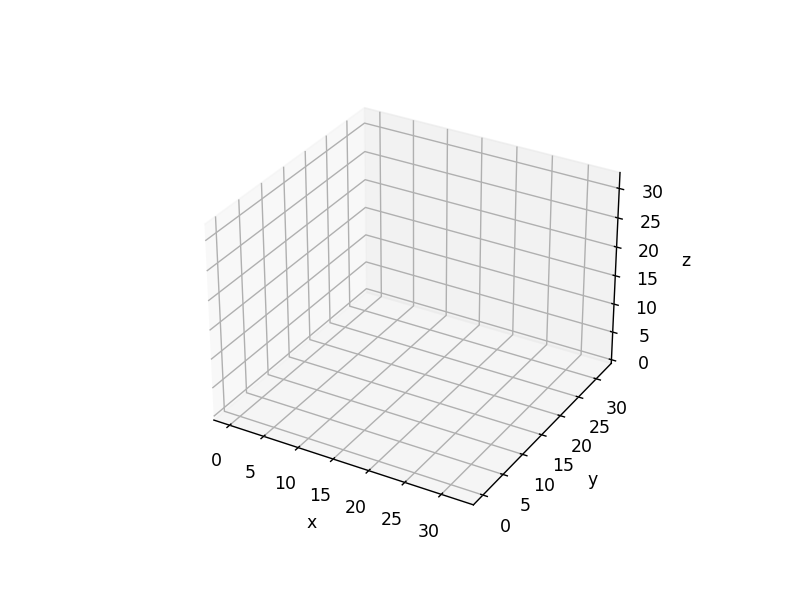

In [244]:
G = atomcoord_vox_train[0]
W = [ np.random.normal(size = (7,7,7)) * 1e-1, np.random.normal(size = (5,5,5))*1e-1,  np.ones((3,3,3))*1e-1]
W = [ jnp.array(w) for w in W]

A_hat   = predict(atomcoord_vox[0], W)
ax      = make_ax(True)
ax.voxels( np.array(A_hat) > 0.5 , alpha = 0.5 , lw = 0.1)
plt.show()

# Training

##  $\mathcal L$ function

In [245]:
def A_dissimilarity(A_hat,A_adt):
    positivi_totali = (A_adt == 1).sum()
    positivi_errore = jnp.sum( ((A_hat - A_adt)**2) * (A_adt == 1))
    negativi_totali = (A_adt == 0).sum()
    negativi_errore = jnp.sum( ((A_hat - A_adt)**2) * (A_adt == 0))
    return (positivi_errore * negativi_totali + negativi_errore * positivi_totali) / (negativi_totali + positivi_totali)
A_dissimilarity = jax.jit(A_dissimilarity)

def loss(W,G,A):
    A_hat = predict(G,W)
    A_adt = A
    
    L1  = 0.
    for w in W:
        L1 += jnp.abs(w).sum()
    
    return A_dissimilarity(A_hat, A_adt) + 0.01 * L1

loss = jax.jit(loss)
grad = jax.grad(loss)
grad = jax.jit(grad)

In [246]:
def batched_loss(W, G_list, A_list):
    A_hat_list = batched_predict(G_list,W)
    
    L1  = 0.
    for w in W:
        L1 += jnp.abs(w).sum()
    
    
    return jax.vmap( 
        lambda A_hat, A_adt:
        A_dissimilarity(A_hat,A_adt) + 0.01 * L1
    )(A_hat_list, A_list).mean()

batched_loss = jax.jit(batched_loss)
batched_grad = jax.grad(batched_loss)
batched_grad = jax.jit(batched_grad)

In [278]:
%matplotlib inline

import time

W = [  np.random.normal(size = (5,5,5)) * 1e-1 ,  
       np.random.normal(size = (3,3,3)) * 1e-1 ,  
       np.random.normal(size = (3,3,3)) * 1e-1 ,  
       np.random.normal(size = (3,3,3)) * 1e-1 ,  
       np.ones((3,3,3))]
W = [ jnp.array(w) for w in W]


N_train      = len(atomcoord_vox_train)
N_test       = len(atomcoord_vox_test)

epochs = 500
mom_w  = [0*w for w in W]


for e in range(epochs):
    errors = list()
    permutazione = np.random.choice(N_train,size = 10, replace = True) # replacement enables bootstrap
    
    batch_X    = jnp.array(atomcoord_vox_train)[permutazione]
    batch_A    = jnp.array(anchorpts_vox_train)[permutazione]
    
    g = batched_grad(W,batch_X,batch_A)
    for j in range(len(W)):
        mom_w[j] = mom_w[j] * .9 - 0.0001* g[j]
        W[j] += mom_w[j]
      
    train_err = batched_loss(W,batch_X,batch_A).mean() 
    val_err  = batched_loss(W,atomcoord_vox_test,anchorpts_vox_test).mean()
    
    if int( e / (epochs / 10) ) != int( (e + 1) / (epochs / 10)  ):
        print( "train_err = %.3f \t val_loss = %.3f" % (train_err,val_err))

train_err = 13.907 	 val_loss = 17.690
train_err = 8.525 	 val_loss = 8.766
train_err = 6.377 	 val_loss = 7.272
train_err = 5.616 	 val_loss = 6.939
train_err = 6.227 	 val_loss = 6.755
train_err = 6.273 	 val_loss = 6.637
train_err = 5.201 	 val_loss = 6.508
train_err = 4.499 	 val_loss = 6.416
train_err = 5.173 	 val_loss = 6.354
train_err = 5.193 	 val_loss = 6.207


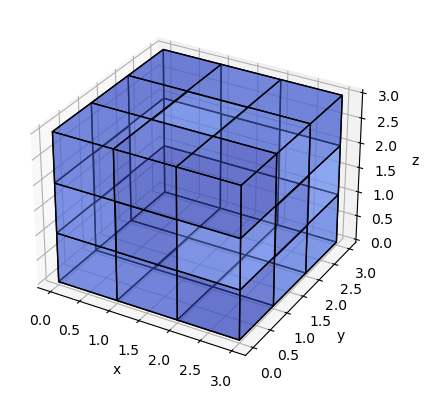

In [279]:
ax = make_ax(True)
k  = 1
colori = (np.array(W[k]) - W[k].min())/(W[k].max() - W[k].min())
colors = plt.cm.coolwarm(W[k])
ax.voxels( np.array(W[k]) , edgecolors='black', facecolors = colors, alpha = 0.5,shade=False)
plt.show()

<IPython.core.display.Javascript object>


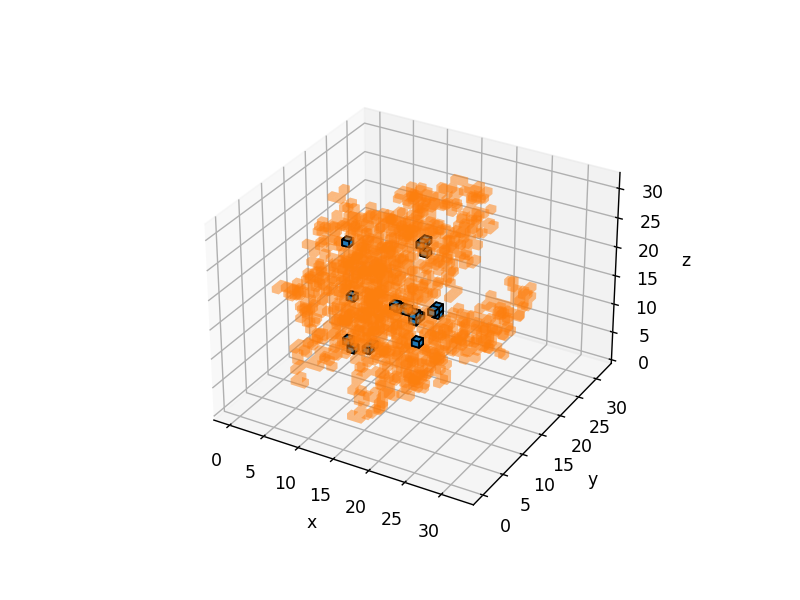

T POS 17.000000
F NEG 2.000000
F POS 13475.000000
T NEG 19274.000000


<IPython.core.display.Javascript object>


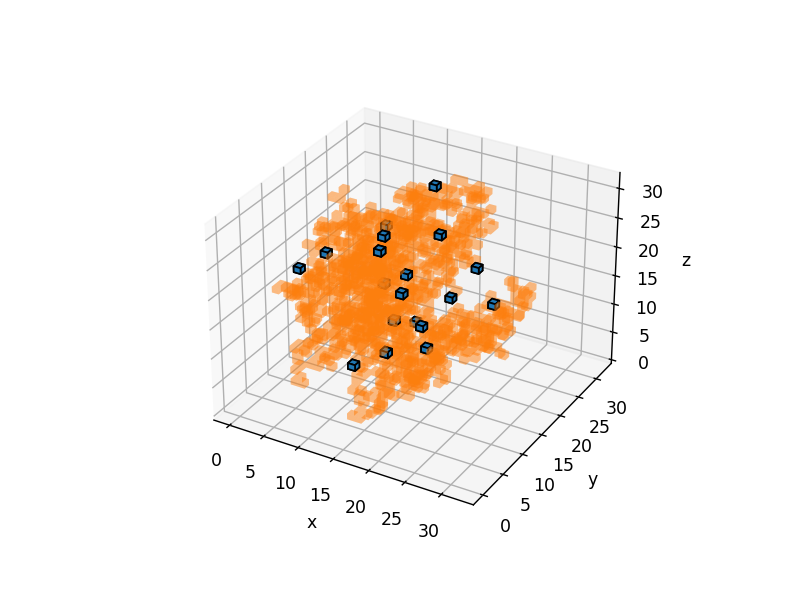

In [280]:
%matplotlib notebook
ax = make_ax(True)
sample = 1
pred   = np.array(predict(atomcoord_vox[sample],W))
toplot = np.zeros(pred.shape)
for i in range(int(anchorpts_vox[sample].sum())):
    idx = np.unravel_index(pred.argmax(), pred.shape)
    toplot[idx] = 1.
    pred[idx] = -100.
    
ax.voxels( toplot , edgecolors='black', shade=False)
ax.voxels(atomcoord_vox[sample], edgecolors='black', lw = 0., shade=False, alpha = 0.3 )
plt.show()


pred   = np.array(predict(atomcoord_vox[sample],W))
positivi = pred > 0.5
negativi = pred < 0.5
veri_positivi = anchorpts_vox[sample] > 0.5
veri_negativi = anchorpts_vox[sample] < 0.5
print("T POS %f" % (positivi * veri_positivi).sum() )
print("F NEG %f" % (negativi * veri_positivi).sum() )
print("F POS %f" % (positivi * veri_negativi).sum() )
print("T NEG %f" % (negativi * veri_negativi).sum() )

ax = make_ax(True)
ax.voxels(anchorpts_vox[sample] , edgecolors='black', shade=False)
ax.voxels(atomcoord_vox[sample], edgecolors='black', lw = 0., shade=False, alpha = 0.3 )
plt.show()